In [1]:
"""
Explosion simulation using GodunovEuler3D and LinesOnField visualization.
"""
import torch
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from IPython.display import display, clear_output

# Import GodunovEuler3D from the CFD package
from godunov_euler import GodunovEuler3D
from LinesOnField import Lines

plt.ion() 

In [2]:
#constant parameters for line visualization
NUM_POLYLINE = 400
LEN_POLYLINE = 2500
NUM_POINTS = 2500

#Constant parameters for 3D Euler solver
#z, y, x
RESOLUTION = 100, 100, 100

X_DOMAIN = [0, 1]
Y_DOMAIN = [0, 1]
Z_DOMAIN = [0, 1]
T_DOMAIN = [0, 0.5]

DX = (X_DOMAIN[1] - X_DOMAIN[0]) / RESOLUTION[2]
DY = (Y_DOMAIN[1] - Y_DOMAIN[0]) / RESOLUTION[1]
DZ = (Z_DOMAIN[1] - Z_DOMAIN[0]) / RESOLUTION[0]

CFL_COEFFICIENT = 0.8
GAMMA = 1.4
TOL = 1e-6

EXPLOSION_DIAMETER = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


Using device: cuda
CUDA device: NVIDIA GeForce GTX 1660 SUPER


In [3]:
def create_uniform_sphere_points(radius):
    center_x = (X_DOMAIN[0] + X_DOMAIN[1]) / 2
    center_y = (Y_DOMAIN[0] + Y_DOMAIN[1]) / 2
    center_z = (Z_DOMAIN[0] + Z_DOMAIN[1]) / 2

    # 구면 좌표계를 사용하여 구 표면의 점들 생성
    # 균등하게 분포된 점들을 생성하기 위해 균등 격자 사용
    # NUM_POLYLINE개의 점을 생성
    num_theta = int(math.sqrt(NUM_POLYLINE * math.pi))  # azimuth 방향 격자 수
    num_phi = int(NUM_POLYLINE / num_theta)  # polar 방향 격자 수

    # 균등하게 분포된 구면 좌표 생성
    theta = torch.linspace(0, 2*math.pi, num_theta, device=device)  # azimuth angle (0 to 2π)
    phi = torch.linspace(0, math.pi, num_phi, device=device)  # polar angle (0 to π)

    # 격자 생성
    theta_grid, phi_grid = torch.meshgrid(theta, phi, indexing='ij')
    theta_flat = theta_grid.flatten()[:NUM_POLYLINE]  # NUM_POLYLINE개만 선택
    phi_flat = phi_grid.flatten()[:NUM_POLYLINE]

    # 구면 좌표를 직교 좌표로 변환
    # x = r * sin(φ) * cos(θ) + center_x
    # y = r * sin(φ) * sin(θ) + center_y
    # z = r * cos(φ) + center_z
    x = radius * torch.sin(phi_flat) * torch.cos(theta_flat) + center_x
    y = radius * torch.sin(phi_flat) * torch.sin(theta_flat) + center_y
    z = radius * torch.cos(phi_flat) + center_z

    # (NUM_POLYLINE, 3) 형태로 결합
    sphere_points = torch.stack([x, y, z], dim=1)  # (NUM_POLYLINE, 3)

    # w 좌표 추가 (homogeneous coordinate)
    w = torch.ones((sphere_points.shape[0], 1), device=device)  # (NUM_POLYLINE, 1)
    sphere_points_3d = torch.cat([sphere_points, w], dim=1)  # (NUM_POLYLINE, 4)

    # 각 polyline에 대해 NUM_POINTS개의 동일한 좌표를 가진 점들 생성
    # (NUM_POLYLINE, 1, 4)로 unsqueeze 후 repeat
    sphere_points_3d = sphere_points_3d.unsqueeze(1)  # (NUM_POLYLINE, 1, 4)
    polylines = sphere_points_3d.repeat(1, NUM_POINTS, 1)  # (NUM_POLYLINE, NUM_POINTS, 4)
    return polylines

def create_random_sphere_points(radius):
    center_x = (X_DOMAIN[0] + X_DOMAIN[1]) / 2
    center_y = (Y_DOMAIN[0] + Y_DOMAIN[1]) / 2
    center_z = (Z_DOMAIN[0] + Z_DOMAIN[1]) / 2

    # u, v ~ Uniform(0, 1)
    u = torch.rand(NUM_POLYLINE, device=device)
    v = torch.rand(NUM_POLYLINE, device=device)

    theta = 2 * torch.pi * u
    phi = torch.acos(2 * v - 1)

    x = center_x + radius * torch.sin(phi) * torch.cos(theta)
    y = center_y + radius * torch.sin(phi) * torch.sin(theta)
    z = center_z + radius * torch.cos(phi)
    w = torch.ones((NUM_POLYLINE), device=device)

    sphere_points_3d = torch.stack([x, y, z, w], dim=1) # (NUM_POLYLINE, 4)

    sphere_points_3d = sphere_points_3d.unsqueeze(1)  # (NUM_POLYLINE, 1, 4)
    polylines = sphere_points_3d.repeat(1, NUM_POINTS, 1)  # (NUM_POLYLINE, NUM_POINTS, 4)
    return polylines

polylines = create_random_sphere_points(EXPLOSION_DIAMETER / 4)
    

(0.0, 1.0)

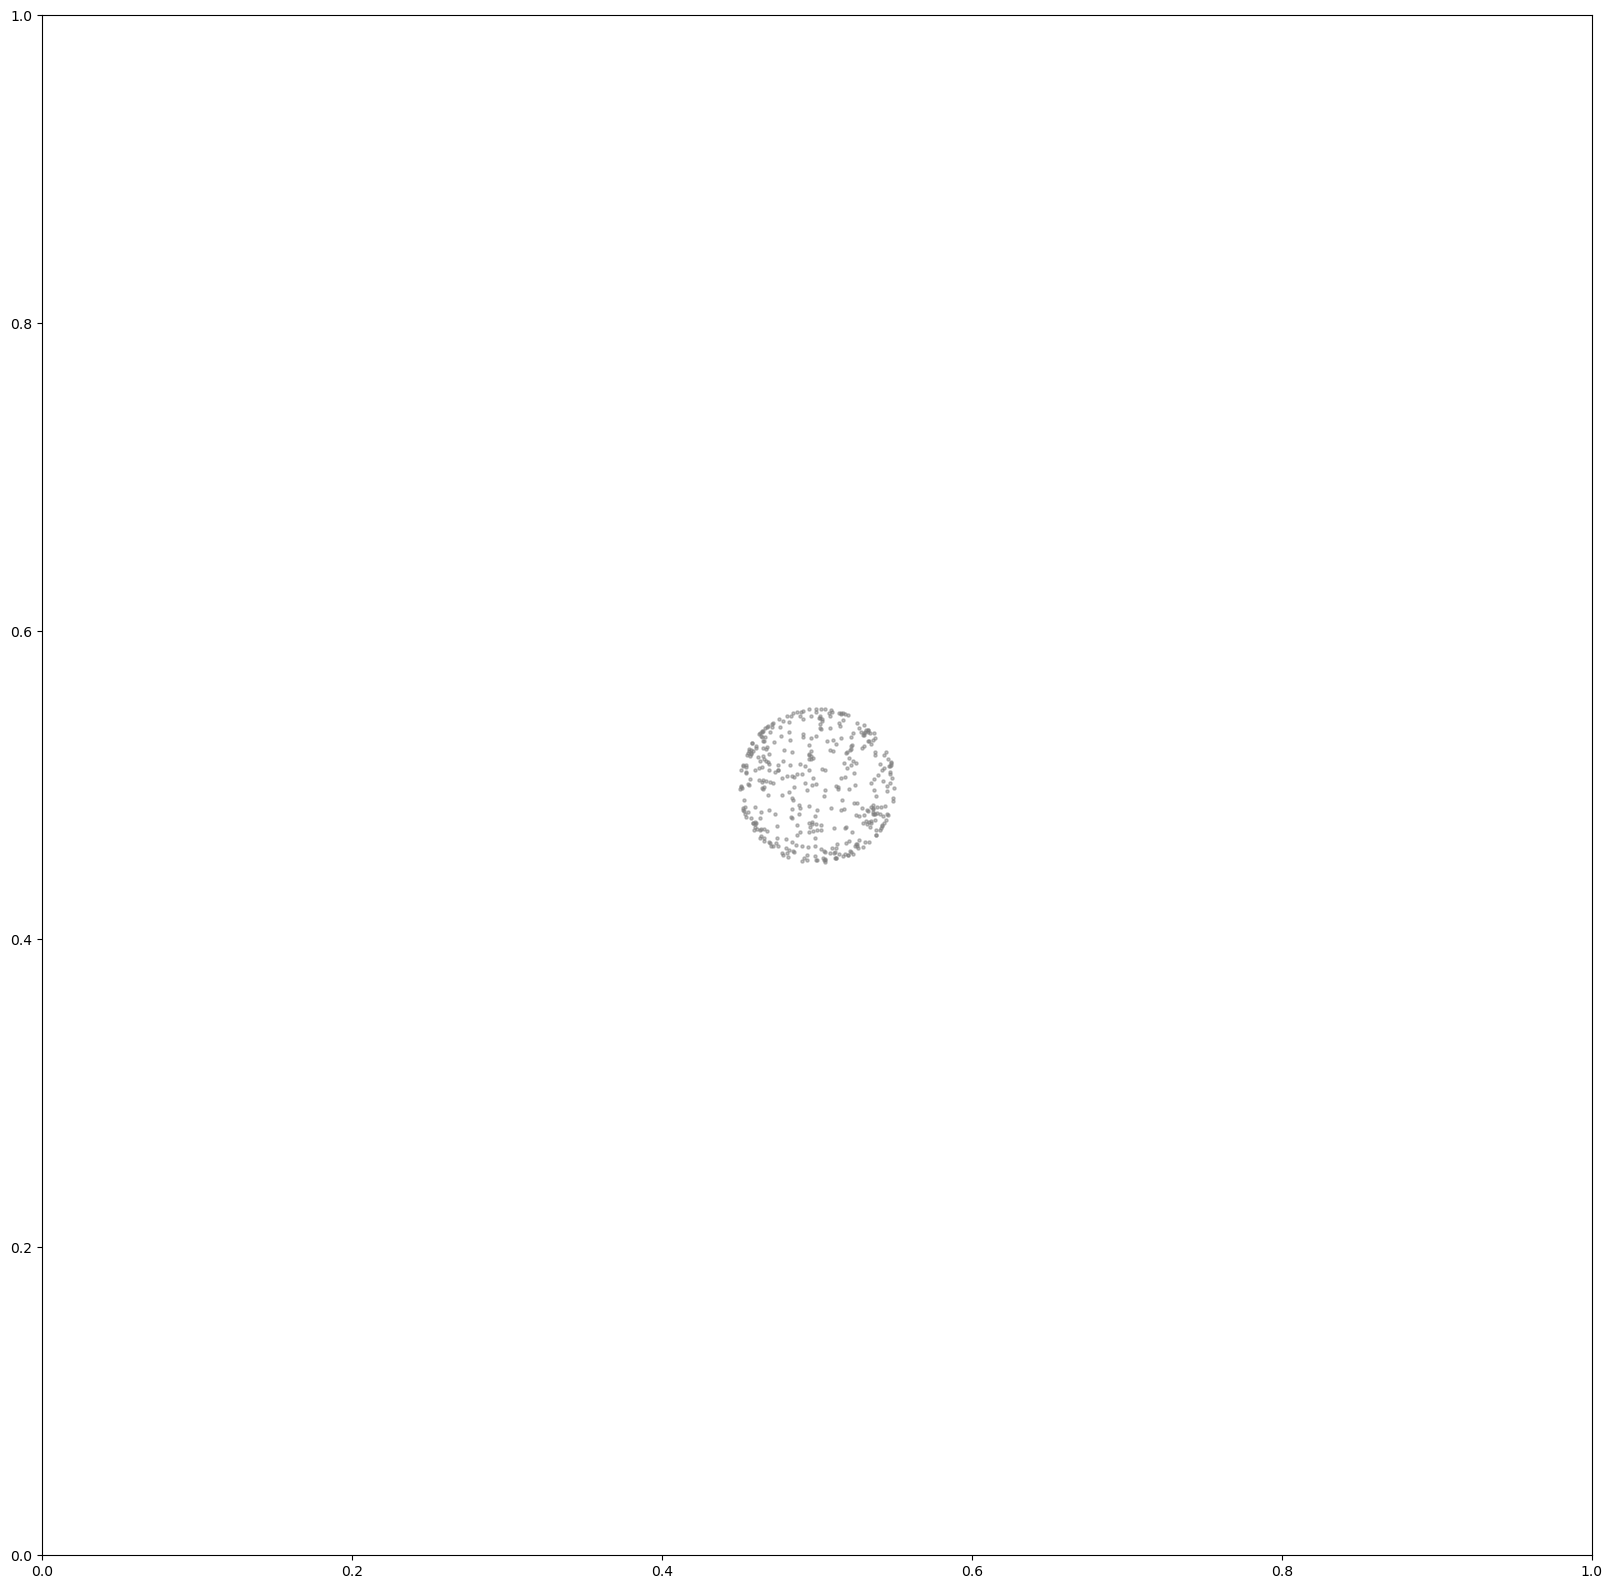

In [4]:
fig, axes = plt.subplots(figsize=(20, 20))  # 1행 2열

# polylines에서 x, y 좌표 추출 및 평탄화
x_coords = polylines[:, 0, 0].cpu().numpy().flatten()  # 모든 x 좌표
z_coords = polylines[:, 0, 2].cpu().numpy().flatten()  # 모든 z 좌표

# scatter로 표시
axes.scatter(x_coords, z_coords, c='gray', s=5, alpha=0.5)
axes.set_xlim(X_DOMAIN[0], X_DOMAIN[1])
axes.set_ylim(Z_DOMAIN[0], Z_DOMAIN[1])


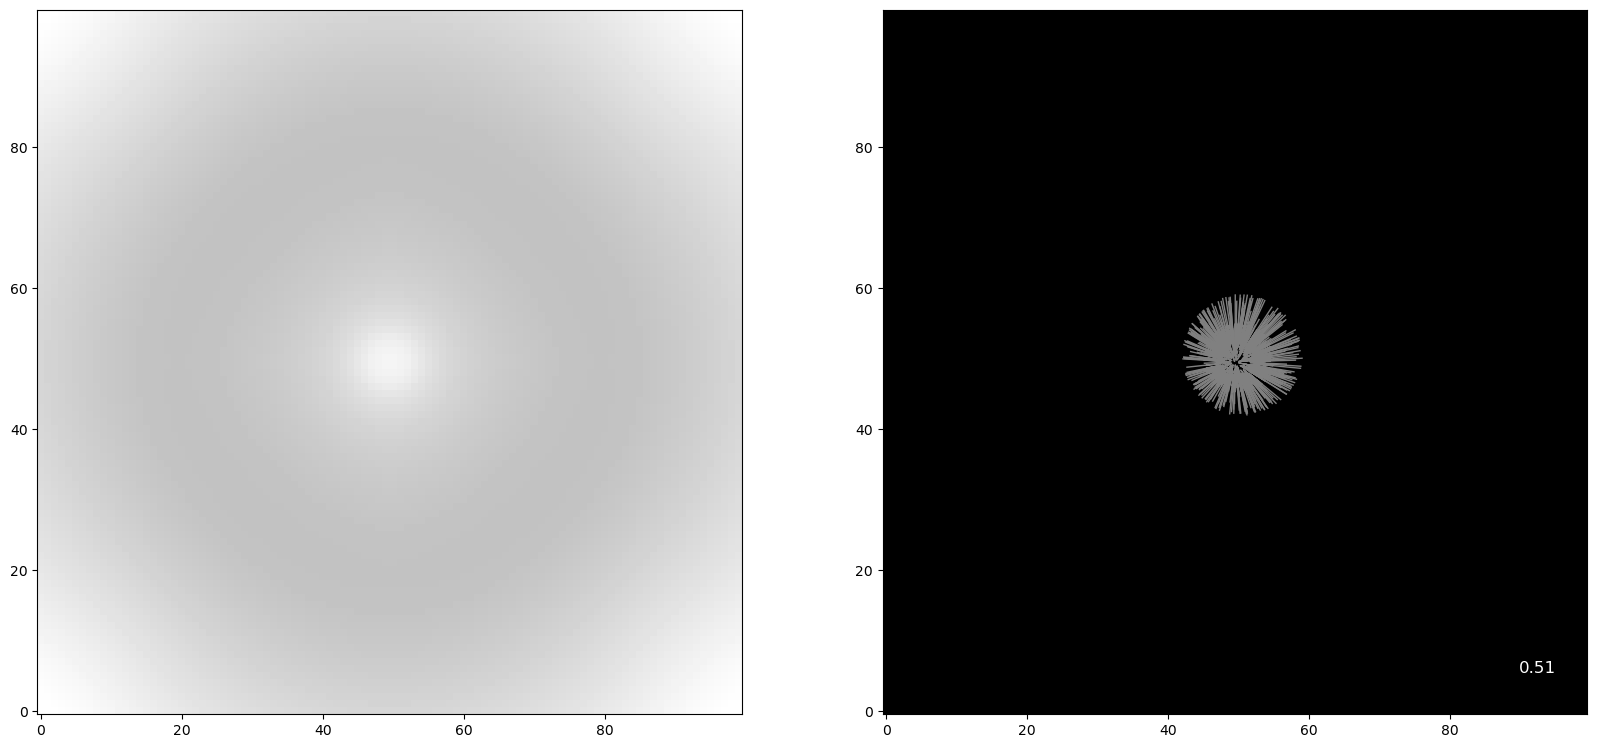

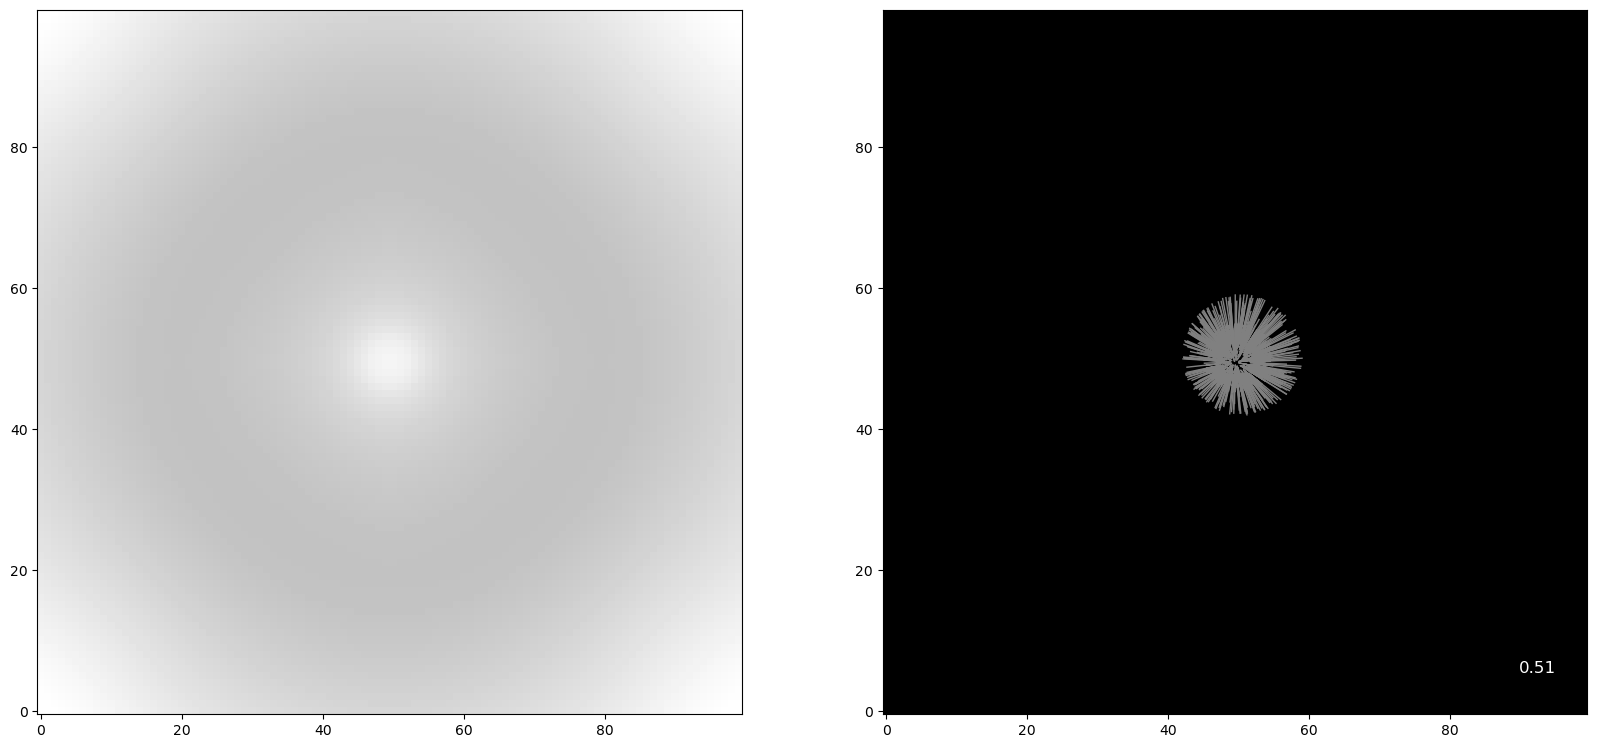

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))  # 1행 2열

im1 = axes[0].imshow(np.zeros(RESOLUTION[:2]), cmap='gray', vmin=0, vmax=1, origin="lower")
im2 = axes[1].imshow(np.zeros(RESOLUTION[:2]), cmap='gray', vmin=0, vmax=1, origin="lower")

line_segments1 = LineCollection([], colors='gray', linewidths=1)

axes[1].add_collection(line_segments1)

time_text = axes[1].text(
            95, 5,  # x=가로 끝-여유, y=밑에서 약간 위
            "", color="white", fontsize=12,
            ha="right", va="bottom", backgroundcolor="black"
        )

#initialize the lines
lines = Lines(polylines, max_length=LEN_POLYLINE)

# Initialize the solver
solver = GodunovEuler3D(
    num_cells_x=RESOLUTION[2],
    num_cells_y=RESOLUTION[1],
    num_cells_z=RESOLUTION[0],
    x_domain=X_DOMAIN,
    y_domain=Y_DOMAIN,
    z_domain=Z_DOMAIN,
    cfl_coefficient=CFL_COEFFICIENT,
    GAMMA=GAMMA,
    tol=TOL,
    device=device
)

# Create explosion initial condition
#cell: nz + 2, ny + 2, nx + 2, 5
cell = solver.create_explosion_initial_condition()

# Run simulation for a few time steps
t = T_DOMAIN[0]

while t < T_DOMAIN[1]:
    clear_output(wait=True)
    
    cell, dt = solver.update(cell)
    
    rho = np.sum(cell[1:-1, 1:-1, 1:-1, 0].cpu().numpy(), axis=1)
    rho = rho / np.max(rho)
    im1.set_data(rho)

    # Grid 간격 계산
    dx = (X_DOMAIN[1] - X_DOMAIN[0]) / RESOLUTION[2]
    dy = (Y_DOMAIN[1] - Y_DOMAIN[0]) / RESOLUTION[1]
    dz = (Z_DOMAIN[1] - Z_DOMAIN[0]) / RESOLUTION[0]
    
    lines.advect(cell[1:-1, 1:-1, 1:-1, 1:4], dt, DX, DY, DZ)
    
    # get_drawing_polylines를 사용하여 periodic boundary 처리 및 numpy 변환
    #drawing_polylines = lines.get_drawing_polylines(RESOLUTION[:2])
    projected_lines = torch.stack([lines.lines[:, :, 0] * RESOLUTION[2], lines.lines[:, :, 2] * RESOLUTION[0]], dim=-1).cpu()
    line_segments1.set_segments(projected_lines)
    
    t += dt
    time_text.set_text(f"{t:.2f}")
    display(fig)

